# タイタニック生存予測 ランダムフォレスト

# Summary

### Tuning
- n_estimators
    - いくつ決定木を作成するか。パターンを列挙。
    - 入力値：integer, optional (default=10)
    - 多ければ多いほど精度が良くなる(=計算時間とのトレードオフ)。

- max_features
    - 各決定木で分類に使用する説明変数の数。目的変数のサンプリング時に、いくつの目的変数をサンプリングするかのパターンを列挙。
    - 入力値：int, float, string or None, optional (default=”auto”)
    - stringの入力候補は、auto”("sqrt”)はn_featuresの平方根、"log2”はlog2(n_features)、"None"だとn_featuresをそのまま使う、など。
    - 1つの説明変数で精度が低い場合は、数を増やすと精度が上がる可能性がある。
- max_depth
    - どの深さの決定木を作成するか
    - 入力値：integer or None, optional (default=None)
    - 深ければ深いほど（数が大きいほど）複雑な分岐になる(=過学習を起こしやすい)
- min_samples_leaf: 決定木の葉に分類されるサンプル数を決めるパラメータ
    - 決定木の葉に分類されるサンプル数
    - 入力値：int, float, optional (default=2)
    - 数が大きいほど木の深さが浅くなる。→過学習を防ぐ


### Evaluation

- Accuracy

```
from sklearn.metrics import accuracy_score

predictions = clf.predict(X_test)
print(accuracy_score(y_test, predictions))
```

- K-Fold Cross-Validation

```
from sklearn.model_selection import KFold, cross_val_score
SEED = 0 # for reproducibility
NSPLITS = 10 # set folds for out-of-fold prediction

#kfold = KFold(ntrain, n_folds= NFOLDS, random_state=SEED)
kfold = KFold(n_splits= NSPLITS, random_state=SEED)

results = cross_val_score(clf, X, y, cv=kfold, n_jobs=-1)
print("Accuracy: %.3f%% (%.3f%%)" % (results.mean()*100.0, results.std()*100.0))
```

- Feature Importance

```
importances = clf.feature_importances_
std = np.std([tree.feature_importances_ for tree in clf.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")
cumsum = 0.0
for f in range(X_train.shape[1]):
    cumsum+=importances[indices[f]]
    print("%d. feature %d (%f) cumsum: %f" % (f + 1, indices[f], importances[indices[f]], cumsum))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X_train.shape[1]), importances[indices],
       color="b", yerr=std[indices], align="center")
plt.xticks(range(X_train.shape[1]), indices)
plt.xlim([-1, X_train.shape[1]])
plt.show()
```

- ROC曲線(Receiver Operating Characteristic)
- AUC (Area Under the Curve)


# 問題定義
* * *

今回の目的は、タイタニックの生存予測を行う。この生存予測を行うことで、このような事故が起こらないようにアクションを起こしていく。

# データ取得/データ読み込み
* * *

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [3]:
#df = sns.load_dataset("titanic")
df = pd.read_csv('../../../mltestdata/01_titanic/train.csv')

data_train = pd.read_csv('../../../mltestdata/01_titanic/train.csv')
data_test = pd.read_csv('../../../mltestdata/01_titanic/train.csv')

In [4]:
data_train.shape

(891, 12)

In [5]:
data_test.shape

(891, 12)

## データ確認

In [6]:
df.sample(frac=0.01, replace=True)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
838,839,1,3,"Chip, Mr. Chang",male,32.0,0,0,1601,56.4958,NaN,S
218,219,1,1,"Bazzani, Miss. Albina",female,32.0,0,0,11813,76.2917,D15,C
795,796,0,2,"Otter, Mr. Richard",male,39.0,0,0,28213,13.0000,NaN,S
123,124,1,2,"Webber, Miss. Susan",female,32.5,0,0,27267,13.0000,E101,S
26,27,0,3,"Emir, Mr. Farred Chehab",male,NaN,0,0,2631,7.2250,NaN,C
665,666,0,2,"Hickman, Mr. Lewis",male,32.0,2,0,S.O.C. 14879,73.5000,NaN,S
673,674,1,2,"Wilhelms, Mr. Charles",male,31.0,0,0,244270,13.0000,NaN,S
92,93,0,1,"Chaffee, Mr. Herbert Fuller",male,46.0,1,0,W.E.P. 5734,61.1750,E31,S
136,137,1,1,"Newsom, Miss. Helen Monypeny",female,19.0,0,2,11752,26.2833,D47,S


In [7]:
df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


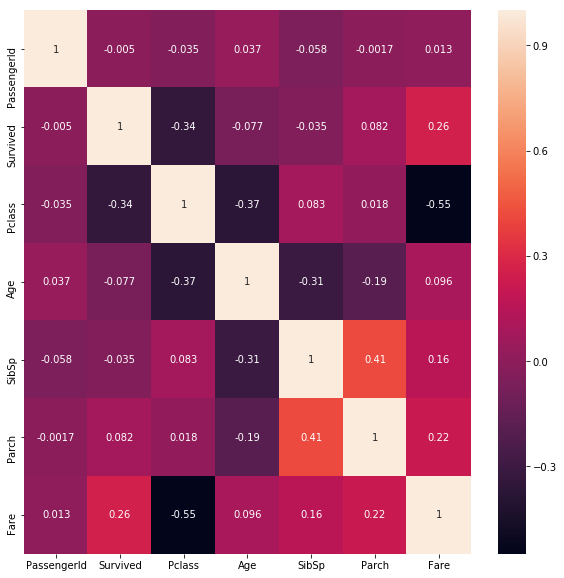

In [8]:
plt.figure(figsize=(10,10))
sns.heatmap(df.corr(), annot=True)
plt.show()

# 前処理について記述せよ
* * *

- __前処理とは何か__

前処理とは使うモデルに投入できるようにデータを加工、変換すること。
（有益なデータソースを探すところも含まれるのかと）

- __なぜ前処理を行う必要があるのか__

データの品質を管理するため（投入するデータに基づいて分析結果が左右される。biasが上がる可能性あり。）


- __前処理は具体的に何を行うか(3つ以上記述せよ)__

    - 分析できるデータフォーマット（配列、データフレーム…）に加工
    - 分析可能なデータの型に変換。名義変数の数量化/カテゴリデータの~~連続データ~~<font color="RED">数値データ化</font>（機械学習では~~連続データ~~<font color="RED">数値データ化</font>を前提にしているものが多いため。ダミー変数化。）あとは日付の形式。
    - 外れ値や欠損値の補完
    - 連続値の離散化/数量変数の離散化（必要であれば）
    - 正規化（必要であれば）

* * *
# [20171028 追記]

__(コメント)__

カテゴリデータを連続データにするという表現ですが、この表現だと語弊があります。
カテゴリデータを数値（整数、one-hot）に変換はしますが、連続データの性質（四則演算ができる性質など）を追加するわけではありません。

__(追加確認内容)__

カテゴリデータは名義尺度に分類され、数値やone hot表記の表現をとること理解しました。下記尺度の分類の確認内容です。

- 数値データ（量的変数） ---定量的（連続的な数値をとる）
 - 比例尺度 
    質量，長さなど
 - 間隔尺度
    摂氏，華氏など（乗除不可） 

- カテゴリデータ（質的変数） ---定性的（離散的な数値をとる）
 - 名義尺度
    名前，電話番号など 
 - 順序尺度
    レースの着順など 
 - 間隔尺度
    摂氏，華氏など（乗除不可） 

機械学習アルゴリズムは数値データを前提としているものが多い。決定木やNativeBayesは数値でないカテゴリカルデータも対応できるが、線形モデルでは対応不可。[The Basics of Encoding Categorical Data for Predictive Models](http://appliedpredictivemodeling.com/blog/2013/10/23/the-basics-of-encoding-categorical-data-for-predictive-models)
* * *

- __前述した具体的な前処理について、その前処理を行うと何を得ることができるか(記述したそれぞれの前処理例について記述せよ)__

    - 分析できるデータフォーマットに加工
        - カラムに沿ったデータの整理。分析可能な特徴量を得ることができる。
    - 分析可能なデータの型に変換。カテゴリデータを~~連続データ~~<font color="RED">数値データ化</font>にする。（機械学習では~~連続データ~~<font color="RED">数値データ化</font>を前提にしているものが多いため。ダミー変数化。）
        - ex) TitanicのSex column. Sex: Male/Female から Male: 1/0に変更。
        - 質的変数を量的変数に変換することができる。
        - n-1個特徴量を作成する。カテゴリが３つ以上の場合は２個。
        
    - 外れ値や欠損値の補完
        - 外れ値は統計的、空間的、またはクラスタリングに基づく方法で外れ値を排除することができる。排除により、分析の計算結果の歪みを防ぐことができる。
        - 欠損値は削除、最尤法、補完をすることで、分析可能なデータセットを得ることができる。データ量も減らすことを避けることができる。

    - 連続値の離散化（必要であれば）
        - 相関がありそうな特徴量で、欠損値を多く含む場合など、存在するデータを離散化・カテゴリに分け、それらの平均値や中央値を使うことで、誤差を含まない外れ値の補完をすることができる。
        
    - 正規化（必要であれば）

* * *
# [20171028 追記]

__(コメント)__

正規化についての具体例の説明。標準化との違いも説明できてると better です。

__(追加確認内容)__
- 特徴量の尺度をそろえることを正規化と呼び、正規化と標準化の２つの方法がある。
- 正規化とは、特徴量を[0,1]の範囲でスケールし直すこと。
- 標準化とは、平均が0、標準偏差が1であるような正規分布としてスケールを合わせること。
* * * 

# 2/前処理について記述せよ


* * *
__前処理について記述せよの調査により、データを確認する際にどのような点を見るとよいか、3つ以上記述せよ。__

- ヒストグラム、平均、標準偏差で関連性の確認
- パラメータの相関係数で相関の強さを確認(連続データ、離散データの両方で)
- 欠損値の確認（あとで補完が必要かもしれないから）


その他メモ
    - 線形回帰分析するなら単回帰分析をとりあえず行う（重回帰分析での指標に使う）


# 前処理を行う
* * *

In [9]:
def simplify_ages(df):
    df.Age = df.Age.fillna(-0.5)
    bins = (-1, 0, 5, 12, 18, 25, 35, 60, 120)
    group_names = ['Unknown', 'Baby', 'Child', 'Teenager', 'Student', 'Young Adult', 'Adult', 'Senior']
    categories = pd.cut(df.Age, bins, labels=group_names)
    df.Age = categories
    return df


def simplify_cabins(df):
    df.Cabin = df.Cabin.fillna('N')
    df.Cabin = df.Cabin.apply(lambda x: x[0])
    return df


def simplify_fares(df):
    df.Fare = df.Fare.fillna(-0.5)
    bins = (-1, 0, 8, 15, 31, 1000)
    group_names = ['Unknown', '1_quartile', '2_quartile', '3_quartile', '4_quartile']
    categories = pd.cut(df.Fare, bins, labels=group_names)
    df.Fare = categories
    return df


def format_name(df):
    df['Lname'] = df.Name.apply(lambda x: x.split(' ')[0])
    df['NamePrefix'] = df.Name.apply(lambda x: x.split(' ')[1])
    return df    


def drop_features(df):
    return df.drop(['Ticket', 'Name', 'Embarked'], axis=1)


def transform_features(df):
    df = simplify_ages(df)
    df = simplify_cabins(df)
    df = simplify_fares(df)
    df = format_name(df)
    df = drop_features(df)
    return df

data_train = transform_features(data_train)
data_test = transform_features(data_test)
data_train.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Lname,NamePrefix
0,1,0,3,male,Student,1,0,1_quartile,N,"Braund,",Mr.
1,2,1,1,female,Adult,1,0,4_quartile,C,"Cumings,",Mrs.
2,3,1,3,female,Young Adult,0,0,1_quartile,N,"Heikkinen,",Miss.
3,4,1,1,female,Young Adult,1,0,4_quartile,C,"Futrelle,",Mrs.
4,5,0,3,male,Young Adult,0,0,2_quartile,N,"Allen,",Mr.


In [10]:
from sklearn import preprocessing
def encode_features(df_train, df_test):
    features = ['Fare', 'Cabin', 'Age', 'Sex', 'Lname', 'NamePrefix']
    df_combined = pd.concat([df_train[features], df_test[features]])

    for feature in features:
        le = preprocessing.LabelEncoder()
        le = le.fit(df_combined[feature])
        df_train[feature] = le.transform(df_train[feature])
        df_test[feature] = le.transform(df_test[feature])
    return df_train, df_test

data_train, data_test = encode_features(data_train, data_test)
data_train.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Lname,NamePrefix
0,1,0,3,1,4,1,0,0,7,73,17
1,2,1,1,0,0,1,0,3,2,136,18
2,3,1,3,0,7,0,0,0,7,251,14
3,4,1,1,0,7,1,0,3,2,198,18
4,5,0,3,1,7,0,0,1,7,11,17


In [11]:
data_train.dtypes

PassengerId    int64
Survived       int64
Pclass         int64
Sex            int64
Age            int64
SibSp          int64
Parch          int64
Fare           int64
Cabin          int64
Lname          int64
NamePrefix     int64
dtype: object

In [12]:
# df["Age"].value_counts()
# data_train["Age"].value_counts()

In [13]:
# data_train.sample(frac=0.01, replace=True)

# 前処理の内容について記述せよ
- 以下の観点をすべて含めて記述しましょう。
- 以上のメソッドがそれぞれ何を行っているか記述せよ
- それぞれなぜそのようなことを行っているか記述せよ(それによって得られるメリットまで考察すること)

simplify_ages
- binsで設定した区間ごとに、group_namesで設定した名前で階級分けをする。df.Ageを階級に置き換える。
- メリット
    - 下記[引用](https://www.msi.co.jp/bayolink/pdf/discretization.pdf)。
    > 一般的にベイジアンネットモデルは状態の数が増えると、確率推論の精度も悪くなります。ノードの状態の最適な個数はモデルの目的や学習データのサイズによって大きく異なりますが、5 個前後に設定するケースが多いようです。

simplify_cabins
- NaNを"N"に置き換え、各値の頭文字一文字に変更。
- メリット
    - カテゴリ化ができ、データが見やすくなる。

simplify_fares
- binsで設定した区間ごとに、group_namesで設定した名前で階級分けをする。df.Fareを階級に置き換える。
- メリットはsimplify_agesと同じ。

format_name
- Name属性を' '(スペース)で分けた0番目の配列をLname、1番目の配列をNamePrefixとして新しい特徴量を追加する。
- メリット
    - 新しい特徴量から分析の幅を広げることができる。

drop_features
- 'Ticket', 'Name', 'Embarked'のカラムを削除する。
- メリット
    - 不要データ、分析済みのデータを削除し、データセットを扱いやすくする。

encode_features
- すでに上記でビンニングしていたカテゴリデータを数値に変更する。
- メリット
    - ２種類の離散データが格納されているカラムについてはダミー変数化ができる。
    - データ記述の簡略 ([引用](https://www.slideshare.net/tetsuroito/tokyor-lt-r))
    - 離散化されたデータしか扱えない手法にも対応できるようにするため。
- デメリット
    - 順序付けが勝手にされる。[labelencorder](https://datascience.stackexchange.com/questions/9443/when-to-use-one-hot-encoding-vs-labelencoder-vs-dictvectorizor)

# モデル選択について記述せよ
* * * 
今回使用するモデルは決定していますが、モデル選択をする際の演習を行いましょう。

- 今回は、生存予測（分類）を行いますが、この分類について使用できそうな手法を4つ以上しらべて記述せよ。
- その手法の概要をそれぞれ記述せよ
- その手法の長所/短所をそれぞれ3つずつ、記述したすべての手法において記述せよ

## ロジスティック回帰
- 概要: 識別モデル。予測結果が0から1までを取るような目的変数。従属変数に２値しか取りえない値を説明変数を用いてその発生確率を説明・予測する多変量解析。
- 長所
    1. ~~線形回帰。ホワイトボックス性高い、説明が明瞭。~~
    2. バリアンスが低い
    3. 発生確率を求めることができる
    4. 決定境界を引く際に有効
- 短所
    1. ~~線形性であること~~  ___(20171028追記) 対象が線形分離問題であること___、説明変数同士が独立であることなど仮定が求められる。
    2. バイアス（予想精度）が高い
    3. 大量のカテゴリデータは正しく扱えない可能性あり([Doesn’t handle large number of categorical features/variables well](https://www.edvancer.in/logistic-regression-vs-decision-trees-vs-svm-part2/))
    4. ___(20171028追記)* [[参考slide.14](https://www.slideshare.net/sakura-mike/ss-65379598)]のように目的関数を高次方程式にすることで線形非分離問題へも対応可だが、___非線形の場合は非線形変換が必要で精度が下がる可能性あり。([Doesn’t perform well when feature space is too large/Relies on transformations for non-linear features](https://www.edvancer.in/logistic-regression-vs-decision-trees-vs-svm-part2/))



([参考1](https://datumstudio.jp/blog/%E6%A9%9F%E6%A2%B0%E5%AD%A6%E7%BF%92%E3%81%AB%E3%81%8A%E3%81%91%E3%82%8B%E3%83%A2%E3%83%87%E3%83%AB%E3%81%AE%E9%81%B8%E6%8A%9E%E6%96%B9%E6%B3%95%E3%81%AB%E3%81%A4%E3%81%84%E3%81%A6))
([参考2](https://github.com/ctufts/Cheat_Sheets/wiki/Classification-Model-Pros-and-Cons))


* * *
# [20171028 追記]

__(コメント)__

varianceが低い/biasが高いとどういったことがそれぞれ起きますでしょうか？（確認）

__(追加確認内容)__

- varianceが低い/biasが高い場合は、訓練データが偏っていても、その偏りに引きずれることはないが、真のデータと結果にずれがある。

- Varianceはアルゴリズムの良し悪しを決めるスペック。
- Var高だと、過学習気味。汎化性能が低い。（モデルが複雑になると教師データに偏りがある場合に結果が偏る可能性がある。）
- Biasは真のデータと学習モデルの結果のデータとのズレ。
- Bias高だと、未学習気味。真のデータと結果が異なっている。（モデルが単純な場合は教師データに偏りがあっても引きずられる度合いは低いが、真のデータとモデルの結果データとはズレがある。）

* * *


* * *
# [20171028 追記]

__(コメント)__

線形/非線形モデル、線形回帰、線形分離可能/不可能問題　という言葉の定義
これらが曖昧にされてるイメージがあります。線形モデルと線形分離可能の「線形」の意味は異なります。「何に対して」それぞれ線形なのか調べてください。

決定木の長所で、非線形属性も取り扱えるとありますが、これは、線形分離不可能問題にも対応しているということでしょうか？もしそうなら、ロジスティック回帰などの線形モデルも、2次以上の項を特徴量としていれれば、線形分離不可能問題にも対応できます。

__(追加確認内容)__

- 線形

    - 「線形」というのは、「目的変数」と「説明変数」の関係性が線形（変数と変数の関係が直線的）であること。モデル内の各項が加法であり、項を乗算するパラメータが1つだけ含まれている場合は線形。
    - （式例）　応答 = 定数 + パラメータ * 予測変数 + ... + パラメータ * 予測変数
    -  非線形形状としては、凹、凸、指数的な増加または減少、シグモイド(S)、および漸近曲線など。例えば「exp」とか「log」とかの関係性が入ると、「線形モデル」ではなくなる。

- 線形モデル
    - 応答 = 定数 + パラメータ * 予測変数 + ... + パラメータ * 予測変数のように線形結合の目的関数をモデル化したもので直線になる。

- 非線形モデル
    - 非線形モデルは曲線。（例）多項式回帰

- 線形回帰
    - 目的関数をあるモデル（コスト関数）に当てはめて、パラメータを求めるまでが線形回帰。
    - 多項式回帰での x に対しては線形ではないが、係数 β （パラメータ）に対しては線形であるため、線形回帰の問題に分類される。[[参考](https://ja.wikipedia.org/wiki/%E7%B7%9A%E5%BD%A2%E5%9B%9E%E5%B8%B0)]



- 線形分離可能/線形分離不可能
    - 線形分離可能とは、線形モデルによってクラス1と0に分離できること。線形分離不可能は線形モデルで分離できないこと。[[参考](https://qiita.com/imaimai1125/items/2a126cf04e64432f1bfd)]

* * * 

## decision tree/決定木(コピー済み)
- 概要：
    - 識別関数。
    - CART（Classification and Regression Tree）法というアルゴリズムを使い、目的変数を最もよく「分類」する、説明変数の分岐を生成する。
    - 目的変数を「最もよく」分類する基準として、CART法ではいくつかの方法があるが、良く使われるのは、ジニ係数、エントロピー（どれだけ情報が整理されたか。低い→better）、分類誤差。
    - エントロピー低→情報ゲイン増。情報ゲインが最大となる質問を各ノードで探し、リーフノードを入れ替え、目的変数を最もよく分類するルートノードを生成する。
    - 分類木は属するカテゴリを、回帰木は連続的な数値を求める。

- 長所
    1. ~~ホワイトボックス性高い、解釈が容易。~~
    2. 非線形分類器として使える。[[Ref](https://www.gixo.jp/blog/3980/)]
    3. 説明変数のエンコード等を検討する必要がないこと。目的変数、説明変数ともにカテゴリ変数と量的変数のどちらも使用可能。[[Ref](https://webcache.googleusercontent.com/search?q=cache:3uVzQK6NgI4J:https://assign-navi.jp/magazine/consultant/c41.html+&cd=1&hl=en&ct=clnk&gl=us)]
    4. データのスケールに対して普遍（スケーリングが不要）
    5. accuracyが高い[[Ref2 slide.33](https://www.slideshare.net/kangdaeki/machine-learning-decision-tree)]
    6. ノイズに強い。

- 短所
    1. 予想精度低。訓練データにかなり依存。決定木はアルゴリズムの性質上、モデルが学習データからうける影響が大きくバリアンスが高い学習モデル([Ref5](http://d.hatena.ne.jp/shakezo/20121221/1356089207))
    2. 不安定→モデルとしてのロバスト性（頑健性）が弱く、適切でない説明変数が入ると、その変数にモデル全体が引っ張られてしまうこと。（訓練データにない範囲に関しては「新しい」答えを生成することができません。）
    3. XORパターンには適用が難しいケースあり

    



* * * 
メモ([引用元](https://github.com/ctufts/Cheat_Sheets/blob/master/Classification_Model_Pros_And_Cons.md))


__Regular (not bagged or boosted)__
- Pros
    1. easy to interpret visually when the trees only contain several levels
    2. Can easily handle qualitative (categorical) features
    3. Works well with decision boundaries parellel to the feature axis
- Cons
    1. prone to overfitting
    2. possible issues with diagonal decision boundaries

__Bagged Trees : train multiple trees using bootstrapped data to reduce variance and prevent overfitting__
- Pros
    1. reduces variance in comparison to regular decision trees
    2. Can provide variable importance measures
        - classification: Gini index
        - regression: RSS
    3. Can easily handle qualitative (categorical) features
    4. Out of bag (OOB) estimates can be used for model validation
- Cons
    1. Not as easy to visually interpret
    2. Does not reduce variance if the features are correlated

__Boosted Trees : Similar to bagging, but learns sequentially and builds off previous trees__
- Pros
    1. Somewhat more interpretable than bagged trees/random forest as the user can define the size of each tree resulting in a collection of stumps (1 level) which can be viewed as an additive model
    2. Can easily handle qualitative (categorical) features
- Cons
    1. Unlike bagging and random forests, can overfit if number of trees is too large

* * * 

## decision foreset/ランダムフォレスト（コピー済み）
- 概要：
    - 識別関数。
    - 決定木ベースの集団学習アルゴリズムのひとつ。
    - 全教師データからランダムにとったデータで学習を行う。([Ref4](https://www.slideshare.net/teppeibaba5/ss-37143977))
    - 説明変数もランダムにすることで、baggingで問題となる各識別器の結果が似てしまう欠点を改善する。
    
- 長所
    1. 説明変数の依存が少ない。ノイズに強い。
    2. 学習が高速→並列に処理できる（それぞれの木で訓練ができる）
    3. 集団学習ではvarianceが低い。
    4. RFではクロスバリデーション必要なし。out-of-bag (oob) エラー計算がその代わりとなる。
    5. 少ないパラメータでチューニング可（木の数自体がもっとも重要）
    6. 非線形も取り扱える
    7. データ量が多くても高速に処理。
       
- 短所
    1. 学習データの説明変数をランダムで抽出するため、データ変数がすくないとうまく学習できない。
    2. コンピューティングの複雑性は木の数に応じてリニアに増える。変数の数が多いと計算量がリニアに増える。
    3. 視覚的な解釈が簡単ではない。


([Ref](https://www.slideshare.net/DanielCahall/cahall-final-intern-presentation))
([Ref2](http://rstudio-pubs-static.s3.amazonaws.com/4239_fcb292ade17648b097a9806fbe026e74.html))
([Ref3](https://www.edvancer.in/logistic-regression-vs-decision-trees-vs-svm-part2/))


## 平均化パーセプトロン
- 概要：学習事例を受け取り、重みベクトルを更新する、という処理を反復した後に重みベクトルと入力ベクトルを足してその値が0以上ならクラス1、0未満はクラス2として分類する。平均化パーセプトロンは過去の反復で学習した重みベクトルの平均を使う。
- 長所
    1. 実装が簡単
    2. よい測定精度が出ることが多い
    3. 迷惑メール判定などオンライン学習に向いている([参考](http://www.nttdata.com/jp/ja/insights/trend_keyword/2014110601.html))
- 短所
    1. 線形分離可能なデータにしか適用できない。
    2. 各反復における重みベクトルを保持する必要があり、メモリ的に学習が非効率である。→問題を考慮した実装方法にすること。
    3. 過学習しやすい。


# モデル選択の基準
* * * 
下記の参考資料を元に、どのような視点からモデルを選択すれば良いか、最低でも3つ以上の視点を記述すること(他の参考資料でも構わない、その場合参考資料を明記すること)

1. 「予測精度」([参考](https://datumstudio.jp/blog/機械学習におけるモデルの選択方法について))
2. 「中身のわかりやすさ」(同上)
3. 訓練・テストデータの分布([P29](https://www.slideshare.net/canard0328/ss-44288984))
4. カテゴリの予測([参考](http://scikit-learn.org/stable/tutorial/machine_learning_map/))
5. 教師データの有り無し(同上)
6. 数量の予測か(同上)

メモ([参考](https://datumstudio.jp/blog/機械学習におけるモデルの選択方法について))：
- 説明変数の予測値への寄与を大雑把に知りたい：線形判別/回帰
- 予測値の正確性が命：ディープラーニング、サポートベクタマシン/回帰
- 予測精度が実用的で因果関係の類推も行いたい：CART(ランダムフォレスト)



# モデル選択におけるデータ可視化
# データ可視化の結果について考察せよ
* * *

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

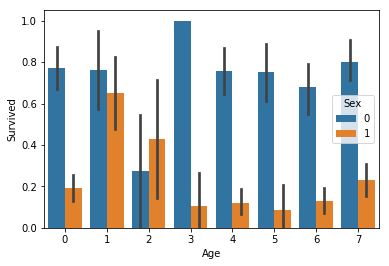

In [15]:
sns.barplot(x="Age", y="Survived", hue="Sex", data=data_train);

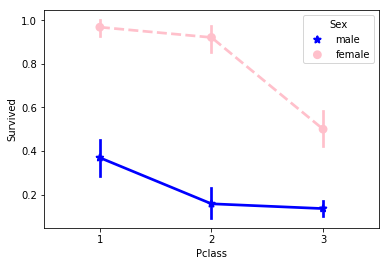

In [16]:
sns.pointplot(x="Pclass", y="Survived", hue="Sex", data=df,
              palette={"male": "blue", "female": "pink"},
              markers=["*", "o"], linestyles=["-", "--"]);

__上記の２つの可視化から分かったことについて考察せよ。__

図1
- 年齢のグループごとにSurvivedの結果に差があることがわかる。
- 特に男女ともにAgeグループ1の生存率が高め。Ageグループ3の女性の生存率はすべて1（信頼区間無し）。
- 全体のグループを通して、女性の生存率のほうが高い。

図2
- 性別とPclassのクロス集計結果でSurvivedの結果に差がある。
- 男性はどのPclassに限らず、生存率が低い
- 女性はどのPclassでも、男性より生存率が高い。
- 特にPclass 1の生存率が高い。

__上記の考察結果から、モデル選択を考える場合、どのようなことが考えられるか__
- 複数の特徴量のクロス集計で生存率が変わることがわかる。各特徴量で分解を行える、決定木が有力。

# データセットの分割
* * *

In [17]:
from sklearn.model_selection import train_test_split

X = data_train.drop(['Survived', 'PassengerId'], axis=1)
y = data_train['Survived']

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=0)

In [18]:
X_train.shape

(712, 9)

In [19]:
X_test.shape

(179, 9)

In [20]:
y_train.shape

(712,)

In [21]:
y_test.shape

(179,)

# ランダムフォレストについて記述せよ
* * *

- 決定木とはどのような手法か(前出の回答のコピー)
    - 識別関数。
    - CART（Classification and Regression Tree）法というアルゴリズムを使い、目的変数を最もよく「分類」する、説明変数の分岐を生成する。
    - 目的変数を「最もよく」分類する基準として、CART法ではいくつかの方法があるが、良く使われるのは、ジニ係数、エントロピー（どれだけ情報が整理されたか。低い→better）、分類誤差。
    - エントロピー低→情報ゲイン増。情報ゲインが最大となる質問を各ノードで探し、リーフノードを入れ替え、目的変数を最もよく分類するルートノードを生成する。

- ランダムフォレストとはどのような手法か(前出の回答のコピー)
    - 識別関数。
    - 決定木ベースの集団学習アルゴリズムのひとつ。
    - 全教師データからランダムにとったデータで学習を行う。([Ref4](https://www.slideshare.net/teppeibaba5/ss-37143977))
    - 説明変数もランダムにすることで、baggingで問題となる各識別器の結果が似てしまう欠点を改善する。
    

- ランダムフォレストの長所と短所をそれぞれ3つ以上挙げてください。(前出の回答のコピー)
    - 長所
        1. 説明変数の依存が少ない。ノイズに強い。
        2. 学習が高速→並列に処理できる（それぞれの木で訓練ができる）
        3. 集団学習ではvarianceが低い。
        4. RFではクロスバリデーション必要なし。out-of-bag (oob) エラー計算がその代わりとなる。
        5. 少ないパラメータでチューニング可（木の数自体がもっとも重要）
        6. 非線形も取り扱える
        7. データ量が多くても高速に処理。

    - 短所
        1. 学習データの説明変数をランダムで抽出するため、データ変数がすくないとうまく学習できない。
        2. コンピューティングの複雑性は木の数に応じてリニアに増える。変数の数が多いと計算量がリニアに増える。
        3. 視覚的な解釈が簡単ではない。

- 今回の目的からランダムフォレストの手法が適する理由を考察し、記述せよ
    - 複数の特徴量のクロス集計で生存率が変わることがわかる。各特徴量で分解を行える、決定木が有力(前出の回答のコピー)。決定木よりも、バリアンスが低いため良い結果が得られる可能性が高い。よってランダムフォレストを採用す使う。


# 学習
* * *

In [22]:
from sklearn.ensemble import RandomForestClassifier
# from sklearn.datasets import make_classification これなに？

clf = RandomForestClassifier()
clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

# accuracyを求めよ
* * *

In [23]:
from sklearn.metrics import accuracy_score

predictions = clf.predict(X_test)
print(accuracy_score(y_test, predictions))

0.826815642458


# 精度を高める
* * *

すでに75%以上の精度のため特になし（あとで上げる）

# ハイパーパラメータについて
* * *

- ハイパーパラメーターとは何か
    - モデリングの前に人間が決めるパラメータで、ランダムフォレストではnum_trees、random_state、max_depthなど。（広義には単回帰(y=ax+b)でいうxもハイパーパラメータ）
    - パラメータはハイパーパラメータのもと機械学習で決まるパラメータで単回帰(y=ax+b)でいうaとb。

- ランダムフォレストにおいてどのようなハイパーパラメーターがあるか4つ以上記述せよ
    - n_estimators
    - max_features
    - max_depth
    - min_samples_leaf
        
- 記述したハイパーパラメーターにおいて、それぞれどのような値が存在するか記述せよ（そのハイパーパラメーターを変化させるとどのようなことが起きるかも記述すること）
    - n_estimators
        - いくつ決定木を作成するか。パターンを列挙。
        - 入力値：integer, optional (default=10)
        - 多ければ多いほど精度が良くなる(=計算時間とのトレードオフ)。
    - max_features
        - 各決定木で分類に使用する説明変数の数。目的変数のサンプリング時に、いくつの目的変数をサンプリングするかのパターンを列挙。
        - 入力値：int, float, string or None, optional (default=”auto”)
            - stringの入力候補は、auto”("sqrt”)はn_featuresの平方根、"log2”はlog2(n_features)、"None"だとn_featuresをそのまま使う、など。
        - 1つの説明変数で精度が低い場合は、数を増やすと精度が上がる可能性がある。
    - max_depth
        - どの深さの決定木を作成するか
        - 入力値：integer or None, optional (default=None)
        - 深ければ深いほど（数が大きいほど）複雑な分岐になる(=過学習を起こしやすい)
    - min_samples_leaf: 決定木の葉に分類されるサンプル数を決めるパラメータ
        - 決定木の葉に分類されるサンプル数
        - 入力値：int, float, optional (default=2)
        - 数が大きいほど木の深さが浅くなる。→過学習を防ぐ


[[Ref](https://qiita.com/kenchin110100/items/24cbb1bcab80c7a6115c)]
[[Ref2](http://ohke.hateblo.jp/entry/2017/08/04/230000)]


# チューニング

In [24]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(
    n_estimators = 4,
    max_features = 'auto',
    criterion = 'gini',
    max_depth = 2,
    min_samples_split = 2,
    min_samples_leaf = 1)

clf.fit(X_train, y_train) #0.793296089385 と下がった。

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=2, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=4, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [25]:
# n_estimatorsのみを変更
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(
    n_estimators = 9, # 6より9の方が結果がよかった。
    max_features = 'auto',
    criterion = 'gini',
    max_depth = 2,
    min_samples_split = 2,
    min_samples_leaf = 1)

clf.fit(X_train, y_train) #0.804469273743

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=2, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=9, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [26]:
from sklearn.metrics import accuracy_score

predictions = clf.predict(X_test)
print(accuracy_score(y_test, predictions))

0.843575418994


- 検証とは何か
学習モデルを評価すること。

- なぜ検証を行う必要があるのか(Accuracyだけではダメな理由も含めること)
学習モデルが過学習・未学習しているかなどの精度の確認する必要がある。

Accuracyは過学習や未学習の精度を含んでいるため、評価の信頼性が比較的低い、かつ汎化性能が検証できない

> パラメータ値を得るために学習に使用した訓練データを性能評価に使用すると過適応（Overfitting）、あるいは未適応（Underfitting）の状態を含んだ見積り値になるため、汎化性能を検証できない。
>[機械学習における学習方法と性能評価の基礎知識](http://www.buildinsider.net/small/bookthinkingmachines/0103)

過学習の確認・改善は下記を使う。
    - 正則化
    - 交差検証によるパラメータチューニング
    - 学習曲線を確認

- 主な検証方法について2つ以上記述せよ
    - K-Fold Cross-Validation
    - ROC曲線(Receiver Operating Characteristic)
    - AUC (Area Under the Curve)


# KFoldについて記述せよ

- K-分割交差検証について説明せよ

    - データをk個に分割してサブサンプルグループを作る。k−1(サブサンプルグループ) で訓練をする。これをk回繰り返す（Test foldされるサブサンプルグループデータは各繰り返しの中でそれぞれ異なる）。それぞれの訓練データで残った1サブサンプルグループの集合がテストデータになる。
    - 上記のように評価用データを変更しながら k 回繰り返した結果の平均を精度に用いることが多い
    - k回繰り返すため、kが大きくなるほど、計算時間がかかる。

[[交差確認（交差検証、Cross-Validation）の簡単な説明](https://mathwords.net/kousakakunin)]

- K-分割交差検証はデータセットを何個に分割するか(まとめて回答)
- データセットを分割する際、その個数はどのように考えると良いか(まとめて回答)
- K-分割交差検証は何回の検証を行うか(まとめて回答)

    - 10個と仮定。
    - データ数が800の場合、
    - サブサンプルグループは80個。
    - 訓練データ数は720個。
    - 交差検証回数は10回。
    - テストデータは80個 x 10セット。


- K-分割交差検証の結果は、最終的にどのように求められるか
    - 。テストデータとモデルの残差の平均二乗誤差（mean square error; MSE）が予測精度の指標としてよく使われる。



# KFoldを実施する

In [27]:
from sklearn.model_selection import KFold, cross_val_score

In [28]:
# Some useful parameters which will come in handy later on
#ntrain = train.shape[0]
#ntest = test.shape[0]
SEED = 0 # for reproducibility
NSPLITS = 10 # set folds for out-of-fold prediction

#kfold = KFold(ntrain, n_folds= NFOLDS, random_state=SEED)
kfold = KFold(n_splits= NSPLITS, random_state=SEED)

In [29]:
#for train_indices, test_indices in kfold.split(X):
#     print('Train: %s | test: %s' % (train_indices, test_indices))

In [30]:
results = cross_val_score(clf, X, y, cv=kfold, n_jobs=-1)

In [31]:
results

array([ 0.8       ,  0.85393258,  0.76404494,  0.78651685,  0.79775281,
        0.82022472,  0.76404494,  0.71910112,  0.83146067,  0.75280899])

In [32]:
print("Accuracy: %.3f%% (%.3f%%)" % (results.mean()*100.0, results.std()*100.0))

Accuracy: 78.899% (3.826%)


# どの特徴量が重要であったかを調査する

In [33]:
importances = clf.feature_importances_

In [34]:
std = np.std([tree.feature_importances_ for tree in clf.estimators_],
             axis=0)

In [35]:
indices = np.argsort(importances)[::-1]

In [36]:
# Print the feature ranking
print("Feature ranking:")
cumsum = 0.0
for f in range(X_train.shape[1]):
    cumsum+=importances[indices[f]]
    print("%d. feature %d (%f) cumsum: %f" % (f + 1, indices[f], importances[indices[f]], cumsum))

Feature ranking:
1. feature 1 (0.317438) cumsum: 0.317438
2. feature 8 (0.245466) cumsum: 0.562904
3. feature 0 (0.183351) cumsum: 0.746255
4. feature 5 (0.116171) cumsum: 0.862426
5. feature 6 (0.094156) cumsum: 0.956582
6. feature 3 (0.040016) cumsum: 0.996598
7. feature 7 (0.003402) cumsum: 1.000000
8. feature 4 (0.000000) cumsum: 1.000000
9. feature 2 (0.000000) cumsum: 1.000000


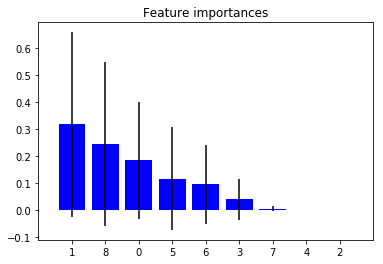

In [37]:
# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X_train.shape[1]), importances[indices],
       color="b", yerr=std[indices], align="center")
plt.xticks(range(X_train.shape[1]), indices)
plt.xlim([-1, X_train.shape[1]])
plt.show()

In [38]:
col_list = list(X_train.columns)
for i in range(len(col_list)):
    print(str(i) + " " + col_list[i])

0 Pclass
1 Sex
2 Age
3 SibSp
4 Parch
5 Fare
6 Cabin
7 Lname
8 NamePrefix


結果より、8 NamePrefix, 0 Pclass, 1 Sex, 6 Cabin, 5 Fareで9割結果に影響する有効な特徴量であることがわかる。  